In [13]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

In [65]:
class CreateDataset:
    """ create the different datasets for the DNN model """
    
    # create the XOR dataset
    def create_xor(self, size):
        # create the entry dataset set
        self.X = np.random.randint(2, size=(2, size))
        self.y = np.sum(self.X, axis=0).reshape((1, size)) # create the lable dataset Y
        self.y[self.y != 1] = 0
        self.X = self.X + (np.random.randn(2, size) / 20) # create noises in the dataset X by adding (-0.6, 0.6) to the data
        return self.X, self.y
    
    # create the Moons dataset
    def create_moon(self, size):
        X, y = make_moons(n_samples=size, shuffle= True, noise=0.1, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)
        X_train = X_train.T
        X_test = X_test.T
        y_train = y_train.reshape(1, -1)
        y_test = y_test.reshape(1, -1)
        return X_train, X_test, y_train, y_test

In [59]:
class Activation:
    """ the abstract class for all activation funtion classes"""
    
    # the basic formula of the activation function for the forward pass
    def formula(self, Z):
        raise NotImplementdError
    
    # to calculate the derivative of the activation function for the backward pass
    def derivative(self, input):
        raise NotImplementdError
    
    # to be used to finetune the initialized weight according to the activation function set for the first layer
    def heuristic(self, layer_b4):
        raise NotImplementdError
    

class Sigmoid(Activation):
    """ all the functions related to the sigmoid activation function """
    
    # the basic formula of the sigmoid function for the forward pass
    def formula(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    # to calculate the derivative of the sigmoid function for the backward pass
    def derivative(self, A):
        return A * (1 - A)
    
    # to be used to finetune the initialized weight if sigmoid function is set for the first layer
    def heuristic(self, layer_b4):
        return np.sqrt(1 / layer_b4)
    

class Tanh(Activation):
    """ all the functions related to the tanh activation function """
    
    # the basic formula of the tanh function for the forward pass
    def formula(self, Z):
        return (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    
    # to calculate the derivative of the tanh function for the backward pass
    def derivative(self, A):
        return 1 - A**2
    
    # to be used to finetune the initialized weight if tanh function is set for the first layer
    def heuristic(self, layer_b4):
        return np.sqrt(1 / layer_b4)
    
    
class Relu(Activation):
    """ all the functions related to the relu activation function """
    
    # the basic formula of the relu function for the forward pass
    def formula(self, Z):
        return (Z > 0) * Z
    
    # to calculate the derivative of the relu function for the backward pass
    def derivative(self, Z):
        return (Z > 0) * 1
    
    # to be used to finetune the initialized weight if relu function is set for the first layer
    def heuristic(self, layer_b4):
        return np.sqrt(2 / layer_b4) 

In [60]:
class Cost:
    """ the abstract class for all the cost functions """
    
    # calculate the cost function
    def formula(self, A, y):
        raise NotImplementedError
    
    # calculate the derivative of the cost function (dA[L]) for the last layer
    def derivative(self, A, y):
        raise NotImplementedError

class LossEntropy(Cost):
    """ Use Loss Entropy to calculate the cost """
    
    # calculate the Lose Entropy cost
    def formula(self, A, y):
        self.m = y.shape[1]
        return - np.sum((y * np.log(A) + (1-y) * np.log(1-A)), axis=1) / self.m
    
    # calculate the derivative of the Lost Entropy cost
    def derivative(self, A, y):
        return - ((np.divide(y, A)) - (np.divide(1-y, 1-A)))

In [61]:
class Layer:
    """ the abstract class for all layer classes """
    
    def __init__(self):
        pass
    
    # implement forward pass
    def forward_pass(self, input):
        raise NotImplementedError
        
    # implement backward pass
    def backward_pass(self, input):
        raise NotImplementedError

        
class FCLayer(Layer):
    
    # initialize parameters
    def __init__(self, layer_b4, layer_after, activation):

        self.activation = activation
        self.W = np.random.randn(layer_after, layer_b4) * getattr(self.activation, 'heuristic')(self, layer_b4)
        self.b = np.zeros((layer_after, 1))
    
    # calculate forward pass: linear fn (Z = WX + b) and non-linear (A = g(Z))
    def forward_pass(self, X):
        self.A_prev = X
        self.Z = np.dot(self.W, X) + self.b
        self.A = getattr(self.activation, 'formula')(self, self.Z)
        return self.A
    
    # calculate backward pass: 
    # dZ = dA * g'(Z))
    # dA[l-1] = W.T * dZ
    def backward_pass(self, dA, learning_rate):
        self.m = dA.shape[1]
        
        self.dZ = dA * getattr(self.activation, 'derivative')(self, self.A)
        pre = np.dot(self.W.T, self.dZ)
        
        self.dW = np.dot(self.dZ, self.A_prev.T) / self.m        
        
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * (np.sum(self.dZ) / self.m)
        
        return np.dot(self.W.T, self.dZ) # dA[l-1]        

In [72]:
class Network:
    """ build the whole L-layer DNN """
    
    def __init__(self):
        self.layers = []
    
    # combine individual layer to form the whole DNN
    def combine(self, layer):
        self.layers.append(layer)
    
    # print cost during training and evaluation
    def print_cost(self,loss_fn, A, y, epoch_number=-1):
        cost = getattr(loss_fn, 'formula')(A, y)
        
        # print cost during training
        if epoch_number != -1:
            print(f'cost of {epoch_number}: {cost}')
        
        # if epoch_number == -1, then we print cost during evaluation
        else:
            print(f'cost: {cost}')

    # get the derivative of the cost function for the last layer (dA[L])
    def get_error_derivative(self, loss_fn, A, y):
        return getattr(loss_fn, 'derivative')(A, y)
    
    # call forward pass function for the whole
    def forward(self, A):
        for layer in self.layers:
            A = layer.forward_pass(A)
        return A
    
    # call backward pass function
    def backward(self, dA, learning_rate):
        for layer in reversed(self.layers):
            dA = layer.backward_pass(dA, learning_rate)
        
    # train the DNN model
    def fit(self, X, y, iteration, loss_fn, learning_rate, print_freq=10000):
        for i in range(iteration):
            
            A = self.forward(X)
            if i % print_freq == 0: self.print_cost(loss_fn, A, y, epoch_number=i)        
            dA = self.get_error_derivative(loss_fn, A, y)
            self.backward(dA, learning_rate)
            
        return A
    
    # predict the result with the trained DNN model
    def predict(self, X):
        probabilities = self.forward(X)      
        predictions = (probabilities >= 0.5) * 1        
        return predictions
    
    # evaluate the performace of the DNN model
    def evaluate(self, X, y, loss_func, dataset_name="dataset", print_cost=False):
        y_hat = self.predict(X)
        accuracy = np.average((y == y_hat) * 1)
        print(f'Accuracy of the {dataset_name}: {accuracy * 100}%')
        if print_cost : self.print_cost(loss_fn, self.forward(X), y)

In [73]:
#
# DATASET CREATION
#
size = 4000
ds = CreateDataset()
# # create XOR dataset
# X_train, y_train = ds.create_xor(size)
# X_test, y_test = ds.create_xor(size)
# create Moons dataset
ds.create_moon(size)
X_train, X_test, y_train, y_test = ds.create_moon(size)


#
# NEURAL NETWORK
#

learning_rate = 0.05
loss_fn = LossEntropy()
iteration = 100000 # 10000 * 1000 * 4

net = Network()
net.combine(FCLayer(2, 3, Relu))
net.combine(FCLayer(3, 1, Sigmoid))

# train the DNN model
A = net.fit(X_train, y_train, iteration, loss_fn, learning_rate)

# predict a result with a test dataset using the trained DNN model
net.evaluate(X_test, y_test, loss_fn, dataset_name="test dataset", print_cost=True)

cost of 0: [0.74222688]
cost of 10000: [0.22924533]
cost of 20000: [0.22583085]
cost of 30000: [0.22352699]
cost of 40000: [0.22197893]
cost of 50000: [0.22032634]
cost of 60000: [0.07315069]
cost of 70000: [0.02201011]
cost of 80000: [0.01382318]
cost of 90000: [0.01052696]
Accuracy of the test dataset: 99.8529411764706%
cost: [0.00937781]


# Visualize dataset and NN Predictions

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# Creation dataset (XOR) Noisy 

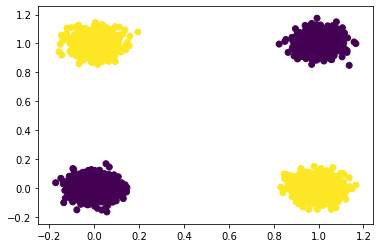

In [21]:
plt.scatter(X[0,:], X[1,:], c=y[0,:])

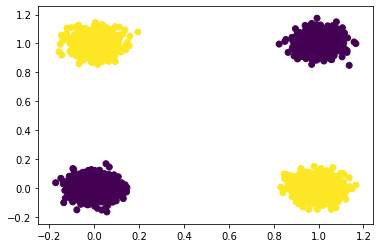

In [22]:
y_pred = net.predict(X)
plt.scatter(X[0,:], X[1,:], c=y_pred[0,:])

# Creation dataset MOONS

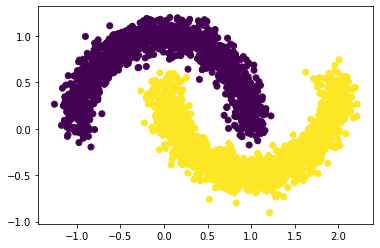

In [76]:
plt.scatter(X_train[0,:], X_train[1,:], c=y_train[0,:])

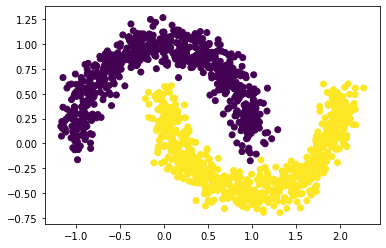

In [78]:
y_pred = net.predict(X_test)
plt.scatter(X_test[0,:], X_test[1,:], c=y_pred[0,:])

# Creation dataset CIRCLES